In [2]:
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torchvision
from torchvision import transforms as T
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

In [3]:
classes = {1: 'Healthy leaf', 
           2: 'Rust',
           3: 'Alternaria leaf spot',
           4: 'Gray spot',
           5: 'Brown spot'}

img_path = 'ATLDSD_dataset/images/'
mask_path = 'ATLDSD_dataset/masks/'

images = sorted(os.listdir(img_path))
masks = sorted(os.listdir(mask_path))

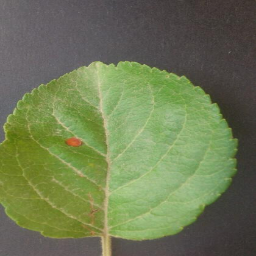

In [4]:
idx = 50
img = Image.open(img_path + images[idx]).convert("RGB")
mask = Image.open(mask_path + masks[idx])

img

In [5]:
labels = np.unique(mask)
labels

array([0, 1, 3], dtype=uint8)

Healthy leaf


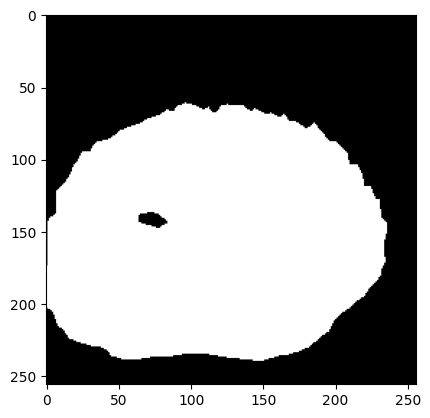

In [6]:
print(classes[labels[1]])
plt.imshow(Image.fromarray(np.array(mask) == labels[1]))

Alternaria leaf spot


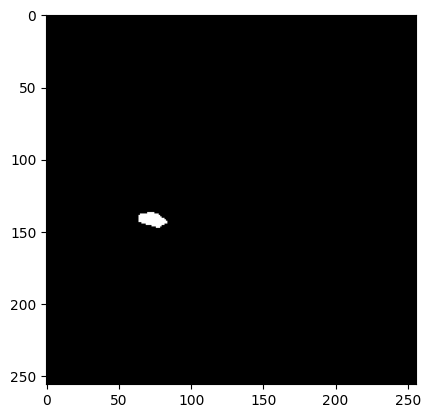

In [7]:
if len(labels)>2:
    print(classes[labels[2]])
    plt.imshow(Image.fromarray(np.array(mask) == labels[2]))

In [8]:
# Custom Dataset Class
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self , images , masks, transform=None):
        self.imgs = images
        self.masks = masks
        self.transform = transform

    def __getitem__(self, idx):
        img = Image.open(img_path + self.imgs[idx]).convert("RGB")
        mask = Image.open(mask_path + self.masks[idx])

        mask = np.array(mask)

        obj_ids = np.unique(mask)
        obj_ids = obj_ids[1:]  # remove background

        num_objs = len(obj_ids)

        masks = np.zeros((num_objs , mask.shape[0] , mask.shape[1]))

        for i in range(num_objs):
            masks[i][mask == obj_ids[i]] = True

        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            if xmin == xmax or ymin == ymax:
                print(f"Invalid bounding box for index {idx} with image {self.imgs[idx]} and mask {self.masks[idx]}")

            if xmin != xmax and ymin != ymax:
                boxes.append([xmin, ymin, xmax, ymax])

        target = {}
        target["boxes"] = torch.as_tensor(boxes, dtype=torch.float32)
        target["labels"] = torch.as_tensor(obj_ids , dtype = torch.int64)
        target["masks"] = torch.as_tensor(masks , dtype = torch.uint8)

        if self.transform is not None:
            img= self.transform(img)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [9]:
# Model Configuration
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes=6)
in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
hidden_layer = 256
model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes=7)

/home/ml-team/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ml-team/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
def custom_collate(data):
  return data

In [11]:
images = sorted(os.listdir(img_path))
masks = sorted(os.listdir(mask_path))
num = int(0.9 * len(images))
num = num if num % 2 == 0 else num + 1
train_imgs_inds = np.random.choice(range(len(images)) , num , replace = False)
val_imgs_inds = np.setdiff1d(range(len(images)) , train_imgs_inds)
train_imgs = np.array(images)[train_imgs_inds]
val_imgs = np.array(images)[val_imgs_inds]
train_masks = np.array(masks)[train_imgs_inds]
val_masks = np.array(masks)[val_imgs_inds]

In [23]:
desired_width = 224
desired_height = 224

desired_transform = T.Compose([
    T.Resize((desired_height, desired_width)),
    T.ToTensor(),
])

In [24]:
train_dl = torch.utils.data.DataLoader(CustomDataset(train_imgs, train_masks, transform=desired_transform), 
                                       batch_size=2, 
                                       shuffle=True, 
                                       collate_fn=custom_collate, 
                                       num_workers=1, 
                                       pin_memory=True if torch.cuda.is_available() else False)

val_dl = torch.utils.data.DataLoader(CustomDataset(val_imgs, val_masks, transform=desired_transform), 
                                     batch_size=2, 
                                     shuffle=True, 
                                     collate_fn=custom_collate, 
                                     num_workers=1, 
                                     pin_memory=True if torch.cuda.is_available() else False)


In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [26]:
model.to(device)

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(256,), max_size=256, mode='bilinear')
  )
  (backbone): VisionTransformer(
    (conv_proj): Conv2d(3, 256, kernel_size=(1, 1), stride=(1, 1))
    (encoder): Encoder(
      (dropout): Dropout(p=0.0, inplace=False)
      (layers): Sequential(
        (encoder_layer_0): EncoderBlock(
          (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (self_attention): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (dropout): Dropout(p=0.0, inplace=False)
          (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): MLPBlock(
            (0): Linear(in_features=768, out_features=3072, bias=True)
            (1): GELU(approximate='none')
            (2): Dropout(p=0.0, inplace=False)
            (3): Linear(in_fe

In [27]:
from torchvision.models.detection.transform import GeneralizedRCNNTransform

# Adjust the transform
min_size = 224
max_size = 224
model.transform = GeneralizedRCNNTransform(min_size=min_size, max_size=max_size,
                                           image_mean=[0.485, 0.456, 0.406],
                                           image_std=[0.229, 0.224, 0.225])

model.to(device)

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(224,), max_size=224, mode='bilinear')
  )
  (backbone): VisionTransformer(
    (conv_proj): Conv2d(3, 256, kernel_size=(1, 1), stride=(1, 1))
    (encoder): Encoder(
      (dropout): Dropout(p=0.0, inplace=False)
      (layers): Sequential(
        (encoder_layer_0): EncoderBlock(
          (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (self_attention): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (dropout): Dropout(p=0.0, inplace=False)
          (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): MLPBlock(
            (0): Linear(in_features=768, out_features=3072, bias=True)
            (1): GELU(approximate='none')
            (2): Dropout(p=0.0, inplace=False)
            (3): Linear(in_fe

In [28]:
params = [p for p in model.parameters() if p.requires_grad]

In [29]:
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

In [30]:
import torch.nn as nn

vit = torchvision.models.vit_b_16(pretrained=True)
vit.conv_proj = nn.Conv2d(3, 256, kernel_size=(1, 1), stride=(1, 1))

In [31]:
for name, param in vit.named_parameters():
    if name != "conv_proj.weight" and name != "conv_proj.bias":
        param.requires_grad = False

In [32]:
vit.heads = None
vit.size_divisibility = 16
vit.padding_constraints = {"square_size": 0}

In [33]:
model.backbone = vit

model.to(device)

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(224,), max_size=224, mode='bilinear')
  )
  (backbone): VisionTransformer(
    (conv_proj): Conv2d(3, 256, kernel_size=(1, 1), stride=(1, 1))
    (encoder): Encoder(
      (dropout): Dropout(p=0.0, inplace=False)
      (layers): Sequential(
        (encoder_layer_0): EncoderBlock(
          (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (self_attention): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (dropout): Dropout(p=0.0, inplace=False)
          (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): MLPBlock(
            (0): Linear(in_features=768, out_features=3072, bias=True)
            (1): GELU(approximate='none')
            (2): Dropout(p=0.0, inplace=False)
            (3): Linear(in_fe

In [34]:
all_train_losses = []
all_val_losses = []
flag = False
for epoch in range(20):
    train_epoch_loss = 0
    val_epoch_loss = 0
    model.train()
    for i , dt in enumerate(train_dl):
        imgs = [dt[0][0].to(device) , dt[1][0].to(device)]
        targ = [dt[0][1] , dt[1][1]]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targ]
        loss = model(imgs , targets)
        if not flag:
            print(loss)
            flag = True
        losses = sum([l for l in loss.values()])
        train_epoch_loss += losses.cpu().detach().numpy()
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
    all_train_losses.append(train_epoch_loss)
    with torch.no_grad():
        for j , dt in enumerate(val_dl):
            if len(dt) < 2:
                continue
            imgs = [dt[0][0].to(device) , dt[1][0].to(device)]
            targ = [dt[0][1] , dt[1][1]]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targ]
            loss = model(imgs , targets)
            losses = sum([l for l in loss.values()])
            val_epoch_loss += losses.cpu().detach().numpy()
        all_val_losses.append(val_epoch_loss)
    print(epoch , "  " , train_epoch_loss , "  " , val_epoch_loss)

RuntimeError: shape '[2, 768, 196]' is invalid for input of size 25690112

In [35]:
# plt.plot(all_train_losses)

In [36]:
# model.eval()
# img = Image.open("ATLDSD_dataset/images/000417.jpg")
# transform = T.ToTensor()
# ig = transform(img)
# with torch.no_grad():
#     pred = model([ig.to(device)])

In [37]:
# img

In [38]:
# print(classes[pred[0]['labels'][0].item()])
# plt.imshow((pred[0]["masks"][0].cpu().detach().numpy() * 255).astype("uint8").squeeze())

In [39]:
# print(classes[pred[0]['labels'][1].item()])
# plt.imshow((pred[0]["masks"][1].cpu().detach().numpy() * 255).astype("uint8").squeeze())

: 